# The Best Location For A Sports Bar In Toronto

## Introduction/Business Problem

According to research done here, https://www.brightlocal.com/research/local-business-travel-times/, people are willing to drive less distance to go to a specific pub/bar than any other business category besides the gym or yoga / alternative therapies. The location of a sports bar is one of the biggest determinants if it will get enough traffic to pay all of its expenses and eventually turn a profit. Sports bars have become much more popular over the last handful of years and finding a location that still has plenty of demand can be tricky.

Our objective is to recommend the best locations in Toronto to open a new sports bar.

## Data

Coordinate data of Toronto postal codes is in http://cocl.us/Geospatial_data. The data base for Toronto postal code population and total private dwellings are from https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A.

According to the research from Bright Local, on average, people are willing to drive about 14 minutes to a pub of their choice. In a city, we will assume you can drive about 8 km (or 5 miles) in 14 minutes. Using the Foursquare API we will determine how many sports bars are within a 5 mile radius of each postal code. We will then use these numbers to determine the number of sports bars per 5 mile radius there are for each postal code.

We will generate a table with rows corresponding to neighborhood, and columns with
- postal code
- longitude
- lattitude
- population
- sports bars in 5 mile radius
- sports bars per capita

The neighborhood with the least amount of sports bars per capita should be the ones with the most potential demand for a new sports bar.

## Methodology

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


### Create a Table of Toronto Neighborhoods and Their Coordinates

In [2]:
#grabbing table with Toronto neighborhoods and postal codes
table = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=1012023397')

In [3]:
df = table[0]

In [4]:
df.shape

(180, 3)

In [5]:
#dropping Boroughs with 'Not Assigned' as value
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)

In [6]:
df.shape

(103, 3)

In [7]:
#grabbing table of coordinates for Toronto postal codes.
geo_df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
print(geo_df.shape)

(103, 3)


In [9]:
#Combine df & geo_df into one df
df_hoods = df.set_index('Postal Code')
df_hoods.head()

,Borough,Neighbourhood
Postal Code,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [10]:
geo_df.set_index('Postal Code', inplace=True)
geo_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [11]:
df_grouped = pd.concat([df_hoods, geo_df], axis=1, join='inner')
df_grouped.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [12]:
df_grouped.index.name = 'PostalCode'
df_grouped.reset_index(inplace=True)

In [13]:
df_grouped.rename(columns = {'Neighbourhood': 'Neighborhood'}, inplace=True)
print(df_grouped.shape)
df_grouped.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Reducing the boroughs to only include those with Toronto in the name.

In [14]:
toronto_boroughs = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']
toronto_df = df_grouped[df_grouped['Borough'].isin(toronto_boroughs)].reset_index(drop=True)
print(toronto_df.shape)
toronto_df.head()

(39, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [15]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post, borough, neigh in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['PostalCode'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


## Pull Sports Bar Location Data via FourSquare

In [16]:
CLIENT_ID = 'IPWMPFWCJFDID0VN2T1BH13WB4B4ZFROE1V2RBKTWWTSESHW' # your Foursquare ID
CLIENT_SECRET = '2H4L3LBMLKUXHDYPMCMCUPOQ2QAUH5JSQ4D5BZJBAI1WOWGJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IPWMPFWCJFDID0VN2T1BH13WB4B4ZFROE1V2RBKTWWTSESHW
CLIENT_SECRET:2H4L3LBMLKUXHDYPMCMCUPOQ2QAUH5JSQ4D5BZJBAI1WOWGJ


## Call Sports Bars within a 8 km radius of each neighborhood into a dataframe

In [17]:
# radius is in meters. 
radius = 8000
LIMIT = 100

venues = []

for lat, long, post, borough, neighboUrhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['PostalCode'], toronto_df['Borough'], toronto_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&query=sports,bar&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    

    results = requests.get(url).json()["response"]['groups'][0]['items']
    

    for venue in results:
        venues.append((
            post, 
            borough,
            neigh,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

venues_df = pd.DataFrame(venues)
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
print(venues_df.shape)
venues_df.head(20)

(2349, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,RS - Real Sports,43.642558,-79.379965,Sports Bar
1,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Local Leaside,43.710012,-79.363514,Sports Bar
2,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,The Pint Public House,43.643301,-79.388686,Sports Bar
3,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Mayday Malone's,43.672620,-79.414137,Sports Bar
4,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Football Factory,43.646499,-79.403637,Sports Bar
5,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Opera Bob's Public House,43.649565,-79.420054,Sports Bar
6,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Boston Pizza,43.659338,-79.382260,Sports Bar
7,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,hbar,43.645837,-79.410490,Sports Bar
8,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,St. Louis Bar and Grill,43.663853,-79.384187,Sports Bar
9,M5A,Downtown Toronto,"Business reply mail Processing Centre, South C...",43.65426,-79.360636,Track & Field,43.654204,-79.423747,Sports Bar


In [18]:
postal_sports_bars = venues_df.groupby(['PostalCode', 'Borough', 'Neighborhood'])['VenueName'].count()
postal_sports_bars

PostalCode  Borough           Neighborhood                                                                        
M4E         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    34
M4K         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    65
M4L         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    54
M4M         East Toronto      Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    62
M4N         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    32
M4P         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    62
M4R         Central Toronto   Business reply mail Processing Centre, South Central Letter Processing Plant Toronto    56
M4S         Central Toronto   Business

## Add population data to table with sports bar data

In [19]:
# upload table with postal code population data
postal_pop_scrape = pd.read_html('https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0&CMA=0#tPopDwell')

In [20]:
postal_pop = postal_pop_scrape[0]

In [21]:
postal_pop.shape

(1643, 4)

In [22]:
postal_pop.drop(index=[0], axis=0, inplace=True)
postal_pop.head()

,Geographic name,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
1,CanadaFootnote 1,35151728.0,15412443.0,14072079.0
2,A0A,46587.0,26155.0,19426.0
3,A0B,19792.0,13658.0,8792.0
4,A0C,12587.0,8010.0,5606.0
5,A0E,22294.0,12293.0,9603.0


In [23]:
#Drop unnecessary columns from postal_pop
postal_pop.drop(columns= ['Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016'], axis=1, inplace=True)
postal_pop.head()

,Geographic name,"Population, 2016"
1,CanadaFootnote 1,35151728.0
2,A0A,46587.0
3,A0B,19792.0
4,A0C,12587.0
5,A0E,22294.0


In [24]:
#rename Geographic code to 'Postalcode' to match first table
postal_pop.rename(columns = {'Geographic name':'PostalCode'}, inplace = True)
postal_pop.head()

,PostalCode,"Population, 2016"
1,CanadaFootnote 1,35151728.0
2,A0A,46587.0
3,A0B,19792.0
4,A0C,12587.0
5,A0E,22294.0


In [25]:
#dropping Boroughs without 'M' prefix
#postal_pop.drop([1:894], axis=0, inplace=True)
#postal_pop.head(20)
#998:1642

In [26]:
print(postal_pop[postal_pop['PostalCode'].str.contains('M')])

     PostalCode  Population, 2016
11          A0M            6200.0
23          A1M            8058.0
43          B0M           16997.0
60          B1M            1130.0
93          B3M           32204.0
139         E2M           18715.0
164         E4M            1772.0
184         E5M            2028.0
209         E7M            9908.0
220         E8M            2059.0
240         G0M           34021.0
260         G1M           19697.0
278         G2M            5301.0
289         G3M            7200.0
306         G5M            8471.0
354         G8M            5286.0
371         H0M            1202.0
381         H1M           29359.0
401         H2M           18621.0
421         H3M           15478.0
441         H4M           12325.0
463         H7M           27898.0
502         J0M           23550.0
521         J1M            5376.0
537         J2M            6941.0
551         J3M           10751.0
566         J4M           13048.0
583         J5M           20788.0
613         J7

In [27]:
#Merging the two dfs
Table= pd.merge(postal_sports_bars, postal_pop, on='PostalCode', how='inner')
Table

,PostalCode,VenueName,"Population, 2016"
0,M4E,34,25044.0
1,M4K,65,31583.0
2,M4L,54,32640.0
3,M4M,62,24689.0
4,M4N,32,15330.0
5,M4P,62,20039.0
6,M4R,56,11394.0
7,M4S,71,26506.0
8,M4T,67,10463.0
9,M4V,64,18241.0


In [28]:
Table.rename(columns = {'VenueName':'Sports Bars in 8km radius'}, inplace = True)
Table

,PostalCode,Sports Bars in 8km radius,"Population, 2016"
0,M4E,34,25044.0
1,M4K,65,31583.0
2,M4L,54,32640.0
3,M4M,62,24689.0
4,M4N,32,15330.0
5,M4P,62,20039.0
6,M4R,56,11394.0
7,M4S,71,26506.0
8,M4T,67,10463.0
9,M4V,64,18241.0


In [29]:
#adding column to show breweries per capita
Table['Sports Bars Per Capita']= Table['Population, 2016']/Table['Sports Bars in 8km radius']
Table.head()

,PostalCode,Sports Bars in 8km radius,"Population, 2016",Sports Bars Per Capita
0,M4E,34,25044.0,736.588235
1,M4K,65,31583.0,485.892308
2,M4L,54,32640.0,604.444444
3,M4M,62,24689.0,398.209677
4,M4N,32,15330.0,479.062500


In [30]:
#adding coordinates to final table from geo_df
Table.set_index('PostalCode')

,Sports Bars in 8km radius,"Population, 2016",Sports Bars Per Capita
PostalCode,,,
M4E,34,25044.0,736.588235
M4K,65,31583.0,485.892308
M4L,54,32640.0,604.444444
M4M,62,24689.0,398.209677
M4N,32,15330.0,479.062500
M4P,62,20039.0,323.209677
M4R,56,11394.0,203.464286
M4S,71,26506.0,373.323944
M4T,67,10463.0,156.164179


In [31]:
Table.rename(columns = {'PostalCode':'Postal Code'}, inplace = True)
Table.head()

,Postal Code,Sports Bars in 8km radius,"Population, 2016",Sports Bars Per Capita
0,M4E,34,25044.0,736.588235
1,M4K,65,31583.0,485.892308
2,M4L,54,32640.0,604.444444
3,M4M,62,24689.0,398.209677
4,M4N,32,15330.0,479.062500


In [32]:
Table_Final = pd.merge(Table, geo_df, on='Postal Code', how='inner')
Table_Final

,Postal Code,Sports Bars in 8km radius,"Population, 2016",Sports Bars Per Capita,Latitude,Longitude
0,M4E,34,25044.0,736.588235,43.676357,-79.293031
1,M4K,65,31583.0,485.892308,43.679557,-79.352188
2,M4L,54,32640.0,604.444444,43.668999,-79.315572
3,M4M,62,24689.0,398.209677,43.659526,-79.340923
4,M4N,32,15330.0,479.062500,43.728020,-79.388790
5,M4P,62,20039.0,323.209677,43.712751,-79.390197
6,M4R,56,11394.0,203.464286,43.715383,-79.405678
7,M4S,71,26506.0,373.323944,43.704324,-79.388790
8,M4T,67,10463.0,156.164179,43.689574,-79.383160
9,M4V,64,18241.0,285.015625,43.686412,-79.400049


In [33]:
Table_Final.shape

(39, 6)

In [34]:
# order table from lowest Sports Bars per capita to most
Table_Final.set_index('Postal Code')
Table_Final.sort_values('Sports Bars Per Capita', inplace = True)
Table_Final.head(10)

,Postal Code,Sports Bars in 8km radius,"Population, 2016",Sports Bars Per Capita,Latitude,Longitude
21,M5L,63,0.0,0.000000,43.648198,-79.379817
20,M5K,63,0.0,0.000000,43.647177,-79.381576
37,M7A,64,10.0,0.156250,43.662301,-79.389494
29,M5X,63,10.0,0.158730,43.648429,-79.382280
38,M7Y,53,10.0,0.188679,43.662744,-79.321558
28,M5W,63,15.0,0.238095,43.646435,-79.374846
18,M5H,63,2005.0,31.825397,43.650571,-79.384568
15,M5C,63,2951.0,46.841270,43.651494,-79.375418
17,M5G,64,8423.0,131.609375,43.657952,-79.387383
16,M5E,63,9118.0,144.730159,43.644771,-79.373306


In [35]:
top_spots = Table_Final[:9]
top_spots

,Postal Code,Sports Bars in 8km radius,"Population, 2016",Sports Bars Per Capita,Latitude,Longitude
21,M5L,63,0.0,0.000000,43.648198,-79.379817
20,M5K,63,0.0,0.000000,43.647177,-79.381576
37,M7A,64,10.0,0.156250,43.662301,-79.389494
29,M5X,63,10.0,0.158730,43.648429,-79.382280
38,M7Y,53,10.0,0.188679,43.662744,-79.321558
28,M5W,63,15.0,0.238095,43.646435,-79.374846
18,M5H,63,2005.0,31.825397,43.650571,-79.384568
15,M5C,63,2951.0,46.841270,43.651494,-79.375418
17,M5G,64,8423.0,131.609375,43.657952,-79.387383


In [36]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tl-toronto-neigh")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

map_top_loc = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, long, post in zip(top_spots['Latitude'], top_spots['Longitude'], top_spots['Postal Code']):
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_top_loc)
    
map_top_loc

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


### Createing histogram of Sports Bars per Capita for all locations

In [37]:
import matplotlib.pyplot as plt

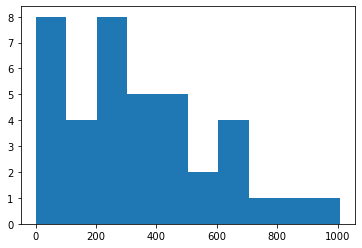

In [38]:
plt.hist(Table_Final['Sports Bars Per Capita'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

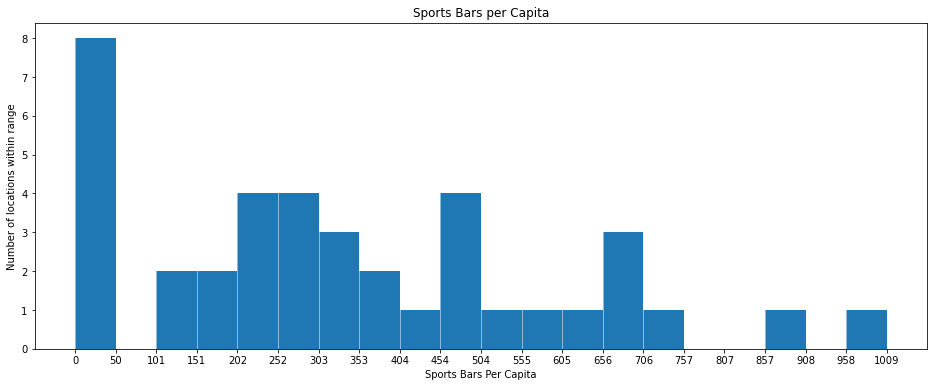

In [39]:
fig = plt.figure(figsize=(16,6))

n, bins, patches = plt.hist(Table_Final['Sports Bars Per Capita'], bins =20)

plt.xticks(bins)
plt.grid(color='white', lw =.5, axis='x')
plt.title('Sports Bars per Capita')
plt.xlabel('Sports Bars Per Capita')
plt.ylabel('Number of locations within range')
plt.show